# RealFit

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
from scipy.integrate import dblquad

In [56]:
# Load the CSV file
file_path = "data/french3.csv"
data = pd.read_csv(file_path)

In [58]:
max_x, max_y, max_h = 1, 2, 1  # Define your max values

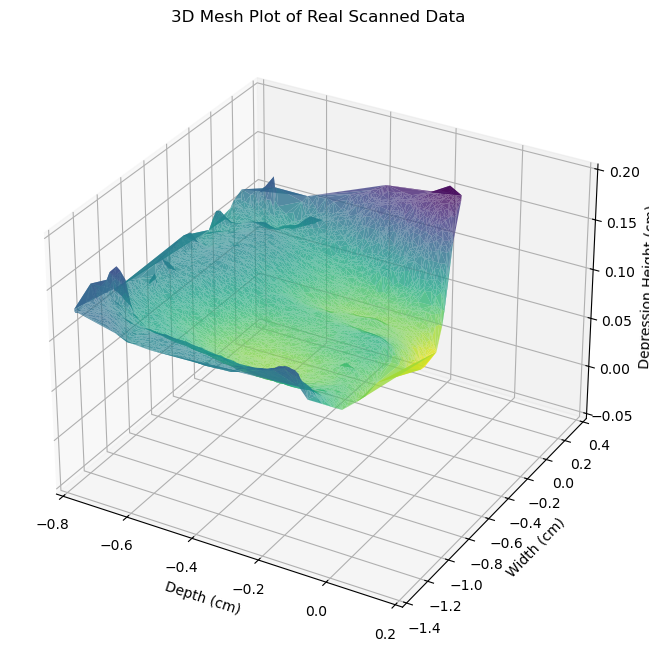

In [88]:
# Ensure the data satisfies the bounds
data = data[(data["X"] <= max_x) & (data["Y"] <= max_y) & (data["H"] <= max_z)]
X, Y, H = data['X'] , data['Y'] , data['H']

# Create a 3D mesh plot for visualization
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X, Y, H, cmap="viridis_r", edgecolor="none", alpha = 0.8)
ax.set_xlabel("Depth (cm)")
ax.set_ylabel("Width (cm)")
ax.set_zlabel("Depression Height (cm)")

ax.set_xlim(-0.8, 0.2)
ax.set_ylim(-1.4, 0.4)
ax.set_zlim(-0.05, 0.2)

plt.title("3D Mesh Plot of Real Scanned Data")
ax.view_init(elev=30, azim=300)

plt.show()

# Stair Height
stair_height = max_h
stair_H = stair_height - H

In [124]:
tX, tY, tH = data['X']+1 , data['Y']+1.5 , -data['H']+0.15

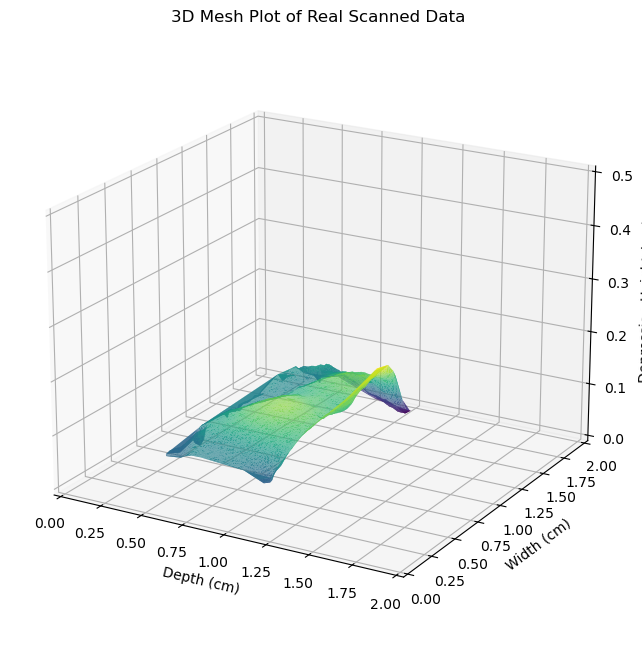

In [138]:
# Create a 3D mesh plot for visualization
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(tX, tY, tH, cmap="viridis", edgecolor="none", alpha = 0.9)
ax.set_xlabel("Depth (cm)")
ax.set_ylabel("Width (cm)")
ax.set_zlabel("Depression Height (cm)")

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_zlim(0, 0.5)

plt.title("3D Mesh Plot of Real Scanned Data")
ax.view_init(elev=20, azim=300)

plt.show()

In [90]:
n_gaussians = 4

In [152]:
# Function to model a single 2D Gaussian distribution
def gaussian_2d(xy, x0, y0, sigma_x, sigma_y, amplitude):
    x, y = xy
    return amplitude * np.exp(-(((x - x0)**2) / (2 * sigma_x**2) + ((y - y0)**2) / (2 * sigma_y**2)))

# Function to model a sum of n_gaussians 2D Gaussian distributions
def sum_of_gaussians(xy, *params):
    n_gaussians = len(params) // 5
    result = np.zeros_like(xy[0])
    for i in range(n_gaussians):
        x0, y0, sigma_x, sigma_y, amplitude = params[i*5:(i+1)*5]
        result += gaussian_2d(xy, x0, y0, sigma_x, sigma_y, amplitude)
    return result

# Initial parameter guesses (randomly distributed means, variances, and amplitudes)
initial_params = []
for _ in range(n_gaussians):
    initial_params += [
        np.random.uniform(0, max_x),  # x0
        np.random.uniform(0, max_y),  # y0
        np.random.uniform(0, max_x / 4),  # sigma_x
        np.random.uniform(0, max_y / 4),  # sigma_y
        np.random.uniform(0, max_h)  # amplitude
    ]

# Fit the data to the sum of Gaussians
xy = np.vstack((X, Y))
lower_bounds = [0, 0, 0, 0, 0] * n_gaussians  # Minimum values for x0, y0, sigma_x, sigma_y, amplitude
upper_bounds = [max_x, max_y, max_x, max_y, max_h] * n_gaussians  # Maximum values
params, _ = curve_fit(sum_of_gaussians, xy, tH, p0=initial_params, bounds=(lower_bounds, upper_bounds), maxfev=1000000)

# Generate a mesh for visualization
x_mesh = np.linspace(0, max_x, 100)
y_mesh = np.linspace(0, max_y, 100)
X_mesh, Y_mesh = np.meshgrid(x_mesh, y_mesh)
xy_mesh = np.vstack((X_mesh.ravel(), Y_mesh.ravel()))

# Calculate the best-fit surface values
H_fit = sum_of_gaussians(xy_mesh, *params).reshape(100, 100)

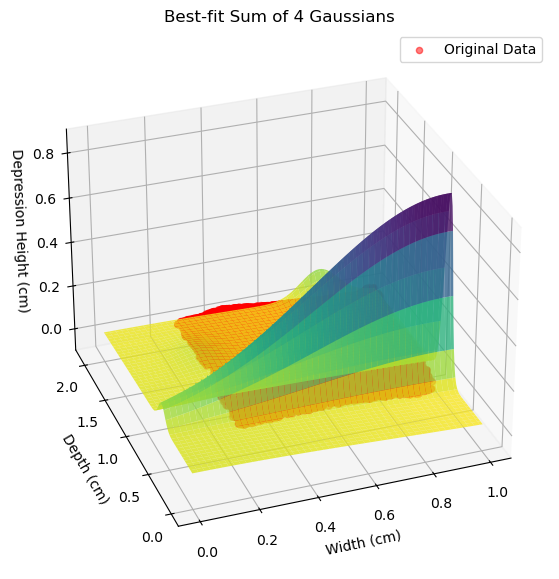

In [154]:
# Plot the results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the original data points
ax.scatter(tX, tY, tH, color='red', label='Original Data', alpha=0.5)

# Plot the best-fit Gaussian surface
ax.plot_surface(X_mesh, Y_mesh, H_fit, cmap='viridis_r', alpha=0.8)

# Set labels and title
ax.set_title(f'Best-fit Sum of {n_gaussians} Gaussians')
ax.set_xlabel('Width (cm)')
ax.set_ylabel('Depth (cm)')
ax.set_zlabel('Depression Height (cm)')
ax.legend()
ax.view_init(elev=30, azim=250)

#plt.savefig("figures/ascentDescentOutputNegative.png", dpi=300)
plt.show()